In [23]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization

In [22]:

class transformer_model:
    #Using this class, we want the input shape and output shape following:
    # inp: batch_size x seq_length x embed_dim
    # output: batch_size x q_seq_length x embed_dim
    
    def __init__(self, inp, num_head):
        self.batch_size = int(inp.shape[0])
        self.seq_length = int(inp.shape[1])
        self.embed_dim = int(inp.shape[2])
        self.num_head = num_head
        assert (self.embed_dim % self.num_head == 0), 'Check the size of embed_dim or num_head'
        self.attention_size = int(self.embed_dim / self.num_head)
        self.scale = self.attention_size ** (-0.5)
        
        # Initialize Dense layers
        self.W_q = Dense(self.embed_dim)  # batch_size x q_tokens x embed_dim
        self.W_k = Dense(self.embed_dim)  # batch_size x k_tokens x embed_dim
        self.W_v = Dense(self.embed_dim)  # batch_size x v_tokens x embed_dim
    
    def head_split(self, inp):
        inp = tf.reshape(inp, (self.batch_size, -1, self.num_head, self.attention_size))
        inp = tf.transpose(inp, perm=[0, 2, 1, 3])
        return inp
    #We calculate self_attention with query, key and value from the same word
    def self_attention(self, q, k, v):
        q = self.W_q(q)  # batch_size x q_tokens x embed_dim
        k = self.W_k(k)
        v = self.W_v(v)
        
        q = self.head_split(q)  # batch_size x num_head x q_seq_length x attention_size
        k = self.head_split(k)  # batch_size x num_head x k_seq_length x attention_size
        k = tf.transpose(k, perm=[0, 1, 3, 2])
        v = self.head_split(v)  # batch_size x num_head x v_seq_length x attention_size
        
        qk = tf.matmul(q, k)  # batch_size x num_head x q_seq_length x k_seq_length
        soft_qk = tf.nn.softmax(qk * self.scale)
        result = tf.matmul(soft_qk, v)  # Use soft_qk instead of qk
        result = tf.transpose(result, perm=[0, 2, 1, 3])
        result = tf.reshape(result, (self.batch_size, -1, self.embed_dim))
        
        return result  # batch_size x q_seq_length x embed_dim
    #We call this to calculate a decent output after going through transformer's encoder part, or BERT architecture
    def transformer(self, input_tensor, embed_dim, attention_mask,
                    num_head, layers, 
                    intermediate_size, dropout, do_return_all_layers):
        if embed_dim % num_head != 0:
            raise ValueError(f"The hidden size ({embed_dim}) is not a multiple of the number of attention heads ({num_head})")
        
        input_shape = input_tensor.shape
        batch_size, seq_length = input_shape[0], input_shape[1]
        all_layers_output = []
        
        # Loop through layers
        for layer_idx in range(layers):
            with tf.name_scope(f"layer_{layer_idx}"):
                layer_input = input_tensor  # batch_size x seq_length x embed_dim
                with tf.name_scope("attention"):
                    attention_heads = []
                    attention_head = self.self_attention(layer_input, layer_input, layer_input)  # batch_size x q_seq_length x embed_dim
                    attention_heads.append(attention_head)
                    attention_output = None
                    if len(attention_heads) == 1:
                        attention_output = attention_heads[0]  # batch_size x q_seq_length x embed_dim
                    else:
                        attention_output = tf.concat(attention_heads, axis=-1)  # batch_size x q_seq_length x (embed_dim * num of layers)
                
                with tf.name_scope('output'):
                    attention_output = Dense(embed_dim)(attention_output)  # batch_size x q_seq_length x embed_dim
                
                with tf.name_scope('intermediate'):
                    intermediate_output = Dense(intermediate_size, activation='tanh')(attention_output)  # batch_size x q_seq_length x intermediate_size
                
                with tf.name_scope('output'):
                    layer_output = Dense(embed_dim)(intermediate_output)
                    layer_output = Dropout(dropout)(layer_output)
                    layer_output = LayerNormalization()(layer_output + attention_output)  # batch_size x q_seq_length x embed_dim
                    input_tensor = layer_output
                    all_layers_output.append(layer_output)  # batch_size x q_seq_length x (embed_dim * num of layers)
        
        if do_return_all_layers:
            return all_layers_output  # List of batch_size x q_seq_length x (embed_dim * num of layers)
        else:
            return input_tensor  # batch_size x q_seq_length x (embed_dim * num of layers)


In [20]:
#The whole architecture of Bert Model
class BertModel:
    def __init__(self, is_training,
                 inp, vocab_size, embed_dim,
                 initializer_range, use_one_hot_embeddings,
                 word_embedding_name, inp_mask = None, scope = None, token_type_ids = None):
        #is_training: true for training model, false for evaluation model
        #inp: batch_size x seq_length
        #inp_mask: batch_size x tokens
#     if not is_training:
#       config.hidden_dropout_prob = 0.0
#       config.attention_probs_dropout_prob = 0.0
        self.batch_size = inp.shape[0]
        self.seq_length = inp.shape[1]
        self.embed_dim = embed_dim
        if inp_mask is None:
            inp_mask = tf.ones((self.batch_size, self.seq_length), dtype = tf.int32)
        if token_type_ids is None:
            token_type_ids = tf.zeros(shape=[self.batch_size, self.seq_length], dtype=tf.int32)
            #token_type_ids: vaguely tell us the order of segments, answering the next sentence prediction task
            #name_scope is used just to name a group of code, maybe useful in tensorboard
        with tf.name_scope(scope or 'bert'):
            with tf.name_scope('embedding'):
                self.embedding_output, self.embedding_table = self.embedding_lookup(inp, vocab_size, initializer_range, use_one_hot_embeddings, word_embedding_name)
                #then we want to add positional embedding and token type embedding to embedding_output
                self.embedding_output = self.embedding_postprocessor(self.embedding_output, initializer_range, True, token_type_ids, 2, True, 512)
            
            with tf.name_scope('encoder'):
                #input: self.embedding_post... : batch_size x seq_length x embed_dim
                #output: 
                attention_mask = self.create_attention_mask_from_input_mask(inp, inp_mask)
                trans_model = transformer_model(self.embedding_output, 3)
                self.all_encoder_layer = trans_model.transformer(self.embedding_output, self.embed_dim, None, 
                                                                 3, 6, 512, 0.2, True) #list of output_layer
                self.sequence_output = self.all_encoder_layer[-1] #final output after all layers
                with tf.name_scope('pooler'):
                    first_token = tf.squeeze(self.sequence_output[:, 0:1, :], axis = 1) #batch_size x 1(first_token) x embed_dim -> batch_size x embed_dim
                    self.pooled_output = Dense(self.embed_dim, activation = 'tanh')(first_token) #batch_size x embed_dim
    def create_attention_mask_from_input_mask(self, from_tensor, to_mask):
        #to_mask = batch_size x seq_length all 1 values
        to_mask = tf.cast(tf.reshape(to_mask, [self.batch_size, 1, self.seq_length]), dtype=tf.int32)
        broadcast_ones = tf.ones((self.batch_size, self.seq_length, 1), dtype=tf.int32)
        
        mask = broadcast_ones * to_mask
        return mask # batch_size x seq_length x seq_length

    def create_initializer(self, initializer_range=0.02):
      #Creates a `truncated_normal_initializer` with the given range."
        return tf.keras.initializers.TruncatedNormal(stddev=initializer_range)
    
        
    def embedding_lookup(self, input_ids, vocab_size, initializer_range = 0.02, used_one_hot_embeddings = False, word_embedding_name = 'word_embedding'):
        #input_ids: batch_size x seq_length
        #input_ids: [128, 0, 0 ,365, 0], [1, 3, 2, 0, 6]
        #why one-hot: first turn the token into one-hot vector, then multiply it with embedding weights
        initializer = self.create_initializer(initializer_range)
        embed_table = tf.Variable(initializer(shape = [vocab_size, self.embed_dim]), name = word_embedding_name)
        #vocab_size x embed_dim 
        flat_input_ids = tf.reshape(input_ids, -1) # (batch_sizexseq_length (or input_ids), )
        flat_input_ids = tf.cast(flat_input_ids, dtype = tf.int32)
        if used_one_hot_embeddings: 
            one_hot_input_ids = tf.one_hot(flat_input_ids, vocab_size) #input_ids x vocab_size
            output = tf.matmul(one_hot_input_ids, embed_table) #input_ids x embed_dim
        else:
            output = tf.gather(embed_table, flat_input_ids) #input_ids x embed_dim
            #it means we take the vector of embedding weights as embed vector for each input_index
        output = tf.reshape(output, [self.batch_size, self.seq_length, self.embed_dim])
        return output, embed_table

    #this function addes the token_type(segment_embedding) and positional_embedding)
    def embedding_postprocessor(self, inp, initializer_range, use_token_type = False,
                                token_type_ids = None,
                                token_type_vocab_size = 16,
                                use_positional = False,
                                max_positional_embedding = 512):
        #inp: batch_size x seq_length x embed_dim
        #token_type_vocab_size: number of segments A, B...
        #token_type_ids: B(2), A(1), C(6).... batch_size x seq_length
        output = inp
        if use_token_type:
            if token_type_ids == None:
                raise ValueError("`token_type_ids` must be specified if"
                       "`use_token_type` is True.")
            initializer = self.create_initializer(initializer_range)
            token_type_table = tf.Variable(initializer(shape=[token_type_vocab_size, self.embed_dim]))
            flat_token_type_ids = tf.reshape(token_type_ids, -1) #(batch_size*seq_length, )
            flat_token_type_ids = tf.cast(flat_token_type_ids, dtype = tf.int32)
            one_hot_ids = tf.one_hot(flat_token_type_ids, depth=token_type_vocab_size)
            #may be: 1 is question, 0 is answer
            #(batch_size x seq_length, token_type_vocab_size)
            token_type_embedding = tf.matmul(one_hot_ids, token_type_table) #input_ids x embed_dim
            token_type_embedding = tf.reshape(token_type_embedding, [self.batch_size, self.seq_length, self.embed_dim])
            output += token_type_embedding #batch_size x self.seq_length x embed_dim
        if use_positional:
            initializer = self.create_initializer(initializer_range)
            full_position_embedding = tf.Variable(initializer(shape = [max_positional_embedding, self.embed_dim]))
            #max_positional_embed_dim x embed_dim
            postional_embedding = tf.slice(full_position_embedding, [0, 0], [self.seq_length, -1]) #seq_length x embed_dim
            num_dims = output.shape.ndims #=3
            postional_embedding = tf.expand_dims(postional_embedding, 0) # 1 x seq_length x embed_dim
            output += postional_embedding #batch_size x seq_length x embed_dim
        return output
                    
        
    
            #token_type_vocab_size x embed_dim
            


In [21]:
#Hyper_parameters
atch_size = 32
seq_length = 100
embed_dim = 129
initializer_range = 0.02
dropout = 0.02
vocab_size = 1000
inp = tf.ones((batch_size, seq_length))
bert = BertModel(True, inp, 1000, embed_dim, 0.02, True, 'La Hihi', None, None, None)
bert.sequence_output


<tf.Tensor: shape=(32, 100, 129), dtype=float32, numpy=
array([[[ 0.7247184 ,  0.20646831, -1.5691347 , ..., -0.33130422,
         -0.01502651,  1.7630924 ],
        [ 0.72471845,  0.20646796, -1.5691346 , ..., -0.33130413,
         -0.01502665,  1.7630923 ],
        [ 0.7247181 ,  0.20646816, -1.5691347 , ..., -0.33130404,
         -0.01502655,  1.763092  ],
        ...,
        [ 0.7247183 ,  0.20646803, -1.5691346 , ..., -0.3313043 ,
         -0.01502666,  1.7630919 ],
        [ 0.72471833,  0.20646784, -1.5691346 , ..., -0.331304  ,
         -0.01502683,  1.7630919 ],
        [ 0.7247182 ,  0.20646802, -1.5691351 , ..., -0.33130407,
         -0.01502673,  1.7630923 ]],

       [[ 0.7247184 ,  0.20646831, -1.5691347 , ..., -0.33130422,
         -0.01502651,  1.7630924 ],
        [ 0.72471845,  0.20646796, -1.5691346 , ..., -0.33130413,
         -0.01502665,  1.7630923 ],
        [ 0.7247181 ,  0.20646816, -1.5691347 , ..., -0.33130404,
         -0.01502655,  1.763092  ],
        ...

In [22]:

print(trans.transformer(inp2, embed_dim, None, 3, 6, 512, 0.2, True))

[<tf.Tensor: shape=(32, 100, 129), dtype=float32, numpy=
array([[[-0.0283174 , -0.44668207,  0.04073503, ..., -0.02114515,
          0.27075857, -0.73335844],
        [-0.0283174 , -0.44668207,  0.04073503, ..., -0.02114515,
          0.27075857, -0.73335844],
        [-0.0283174 , -0.44668207,  0.04073503, ..., -0.02114515,
          0.27075857, -0.73335844],
        ...,
        [-0.0283174 , -0.44668207,  0.04073503, ..., -0.02114515,
          0.27075857, -0.73335844],
        [-0.0283174 , -0.44668207,  0.04073503, ..., -0.02114515,
          0.27075857, -0.73335844],
        [-0.0283174 , -0.44668207,  0.04073503, ..., -0.02114515,
          0.27075857, -0.73335844]],

       [[-0.0283174 , -0.44668207,  0.04073503, ..., -0.02114515,
          0.27075857, -0.73335844],
        [-0.0283174 , -0.44668207,  0.04073503, ..., -0.02114515,
          0.27075857, -0.73335844],
        [-0.0283174 , -0.44668207,  0.04073503, ..., -0.02114515,
          0.27075857, -0.73335844],
        ..

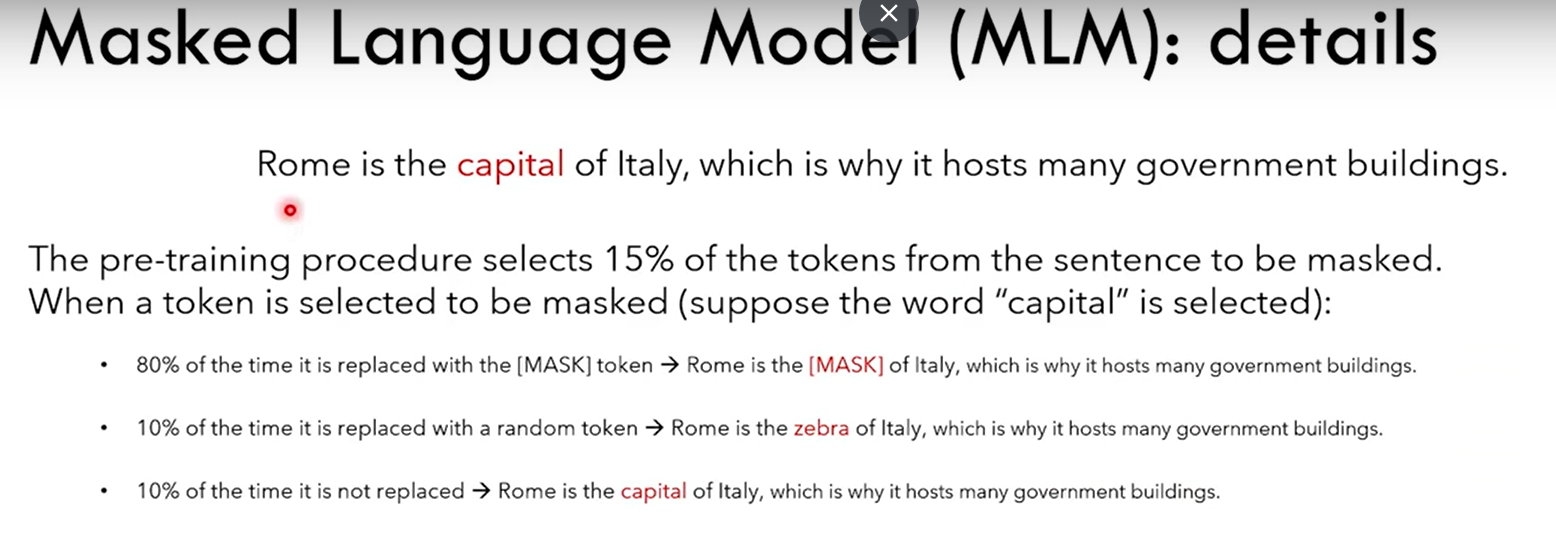

In [33]:
def transformer(input_tensor, embed_dim, attention_mask, num_head, layers,
                intermediate_size, dropout):
    if embed_dim % num_head != 0:
        raise ValueError(f"The hidden size ({embed_dim}) is not a multiple of the number of attention heads ({num_head})"))
    attention_size = embed_dim / num_head
    input_shape = input_tensor.shape
    batch_size, seq_length = input_shape[0], input_shape[1]
    prev_output = tf.reshape(input_tensor, [-1, embed_dim])
    all_layers_output = []
    for layer_idx in range(layers):
        with tf.name_scope(f"layer: {layer_idx}"):
            layer_input = prev_output
            with tf.name_scope("attention"):
                attention_head = 
            with tf.name_scope('intermediate'):
                intermediate_output = Dense(intermediate_size, activation= 'tanh', kernel_initializer = ....)
            
            with tf.name_scope('output'):
                layer_output = Dense(embed_dim)
                layer_output = Dropout(dropout)(layer_output)
                

SyntaxError: unmatched ')' (2706648822.py, line 3)

In [12]:
x = []
y = [1, 2]
x.append(y)
x

[[1, 2]]